<a href="https://colab.research.google.com/github/kavmuni/Machine_learning/blob/main/2812025_Logistic_regression_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# Loading the train and test data into dataframes
titanic_train_df = pd.read_csv('DataSet/train.csv')
titanic_test_df = pd.read_csv('DataSet/test.csv')

In [6]:
for df in [titanic_train_df, titanic_test_df]:
  df['Cabin'] = df.groupby(['Pclass', 'Sex'])['Cabin'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
  df['Age'] = df['Age'].apply(lambda x: round(x) if pd.notna(x) else x)
  df['Age'] = df['Age'].apply(lambda x: 1 if x < 1 else x)
  df['Age'].fillna(df.groupby(['Pclass','Sex', 'Parch', 'SibSp'])['Age'].transform('median'), inplace=True)
  df['Age'].fillna(df.groupby(['Pclass','Sex', 'Parch'])['Age'].transform('median'), inplace=True)
  df['Age'].fillna(df.groupby(['Pclass','Sex'])['Age'].transform('median'), inplace=True)
  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
  df['Fare'].fillna(df.groupby(['Embarked', 'Pclass', 'Cabin'])['Fare'].transform('median'), inplace=True)
  df['Cabin_class'] = df['Pclass'].astype(str) + df['Cabin'].str[0]
  df['Is_alone'] = df.apply(lambda row: 'Y' if row['SibSp'] + row['Parch'] == 0 else 'N', axis=1)
  df['Fare_log'] = df.apply(lambda row: np.log1p(row['Fare']), axis=1)

In [7]:
numerical_cols = ['SibSp','Parch', 'Survived', 'Fare_log']
categorical_cols = ['Sex', 'Cabin_class', 'Is_alone']
numerical_cols_without_survived = ['Parch', 'Fare']


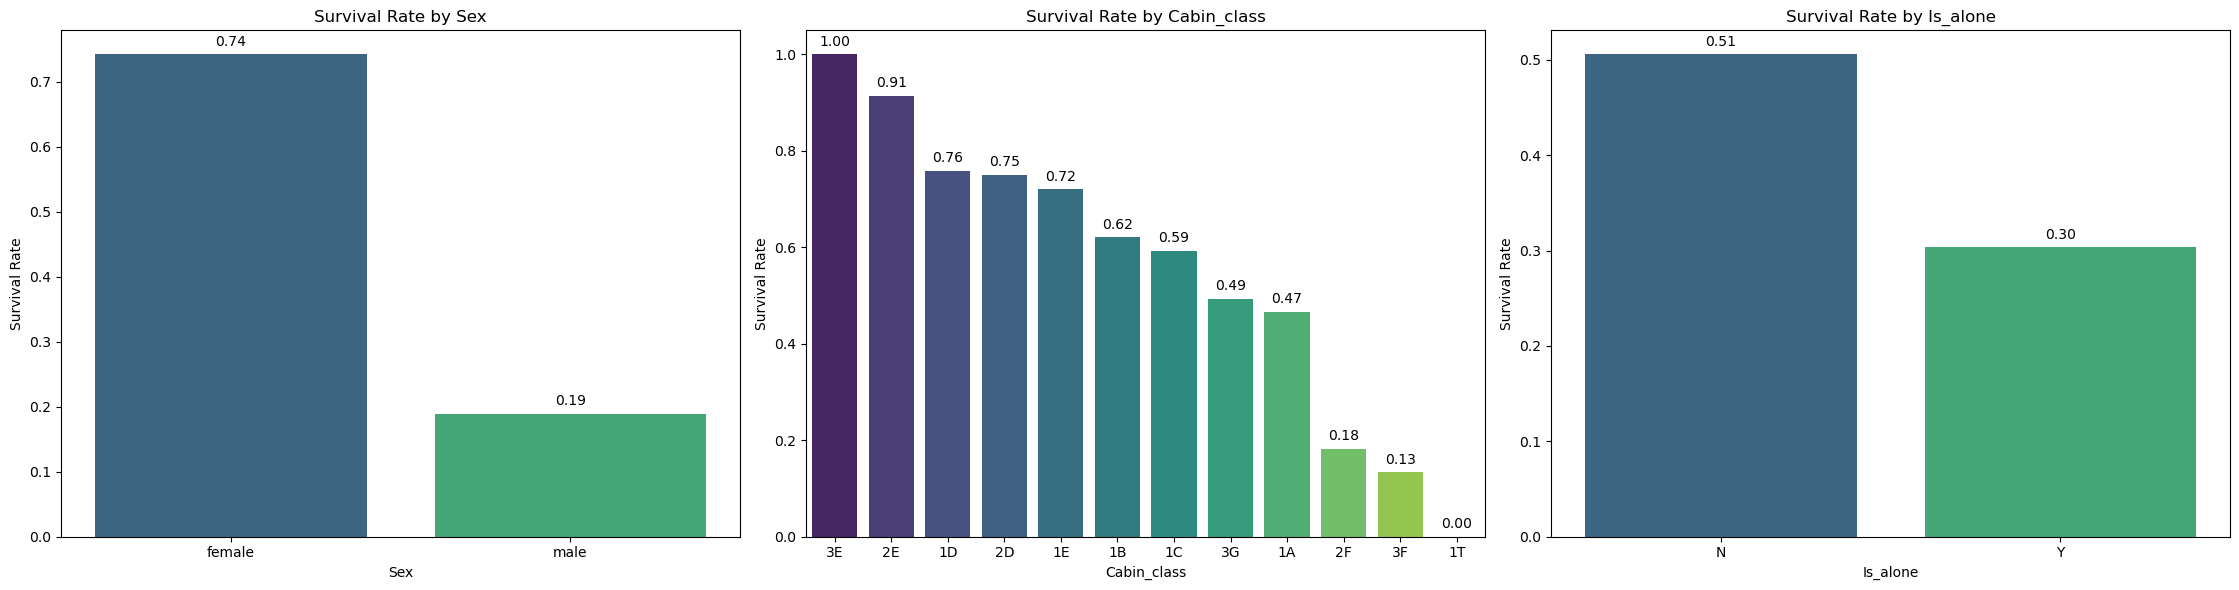

In [8]:
num_plots = len(categorical_cols)

# Calculate optimal grid for subplots, here 1 row, num_plots columns as there are only 2 plots
# If there were more, we might use (num_plots+1)//2 rows and 2 columns
plt.figure(figsize=(7.5 * num_plots, 6)) # Adjust figsize dynamically based on number of plots

for plot_idx, col in enumerate(categorical_cols):
    plt.subplot(1, num_plots, plot_idx + 1) # (rows, columns, current_plot_index)
    survival_rate = titanic_train_df.groupby(col)['Survived'].mean().sort_values(ascending=False);
    ax = sns.barplot(x=survival_rate.index, y=survival_rate.values, palette='viridis')
    plt.title(f'Survival Rate by {col}')
    plt.xlabel(col)
    plt.ylabel('Survival Rate')

    # Add text labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

In [9]:
from itertools import dropwhile
X = titanic_train_df.drop([ 'Age','Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Pclass', 'Fare_log'], axis=1)
y = titanic_train_df['Survived']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()), # Changed to IterativeImputer
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])
preprocess = ColumnTransformer(
    transformers=[
        ("num_transform", numerical_transformer, numerical_cols_without_survived),
        ("cat_transform", categorical_transformer, categorical_cols )

    ]
)
model_preprocess = Pipeline(
         steps = [
                  ('Preprocess', preprocess),
                  ('Model', LogisticRegression(max_iter=1000)) # Increased max_iter for convergence with potentially different imputation
         ]
)
model_preprocess.fit(train_x, train_y)

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Parch', 'Fare']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Cabin_class',
                                                   'Is_alone'])])),
                ('Model', LogisticRegression(max_iter=1000))])

In [10]:
train_pred = model_preprocess.predict(train_x)
print(accuracy_score(train_y, train_pred))
print('****************************')
test_pred = model_preprocess.predict(test_x)
print(accuracy_score(test_y, test_pred))
print('*************TRAIN***************')
print(classification_report(train_y, train_pred))
print('*************TEST***************')
print(classification_report(test_y, test_pred))
print('************TRAIN****************')
print(confusion_matrix(train_y, train_pred))

print('*************TEST***************')
print(confusion_matrix(test_y, test_pred))

0.8089887640449438
****************************
0.7988826815642458
*************TRAIN***************
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       444
           1       0.79      0.67      0.72       268

    accuracy                           0.81       712
   macro avg       0.80      0.78      0.79       712
weighted avg       0.81      0.81      0.81       712

*************TEST***************
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

************TRAIN****************
[[397  47]
 [ 89 179]]
*************TEST***************
[[92 13]
 [23 51]]


In [11]:
model_preprocess_l1 = Pipeline(
         steps = [
                  ('Preprocess', preprocess),
                  ('Model', LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.001)) # Increased max_iter for convergence with potentially different imputation
         ]
)
model_preprocess_l1.fit(train_x, train_y)
train_pred_09 = model_preprocess_l1.predict(train_x)
print(accuracy_score(train_y, train_pred))
print('****************************')
test_pred_09 = model_preprocess_l1.predict(test_x)
print(accuracy_score(test_y, test_pred))
print('*************TRAIN***************')
print(classification_report(train_y, train_pred_09))
print('*************TEST***************')
print(classification_report(test_y, test_pred_09))
print('************TRAIN****************')
print(confusion_matrix(train_y, train_pred_09))

print('*************TEST***************')
print(confusion_matrix(test_y, test_pred_09))

0.8089887640449438
****************************
0.7988826815642458
*************TRAIN***************
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       444
           1       0.80      0.63      0.70       268

    accuracy                           0.80       712
   macro avg       0.80      0.77      0.78       712
weighted avg       0.80      0.80      0.79       712

*************TEST***************
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.66      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179

************TRAIN****************
[[402  42]
 [100 168]]
*************TEST***************
[[95 10]
 [25 49]]


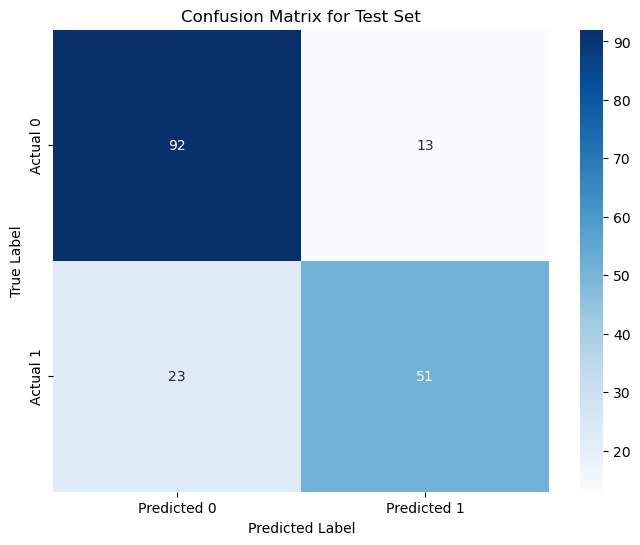

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix for the test set
cm_test = confusion_matrix(test_y, test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
submission_pred_new = model_preprocess.predict(titanic_test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1))
titanic_test_df_01 = titanic_test_df
titanic_test_df_01['Survived'] = submission_pred_new
submission_csv = titanic_test_df_01[['PassengerId', 'Survived']]
submission_csv.to_csv('submission_latest.csv', index=False)

In [14]:
submission_pred_new = model_preprocess_l1.predict(titanic_test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1))
titanic_test_df_02 = titanic_test_df
titanic_test_df_02['Survived'] = submission_pred_new
submission_csv = titanic_test_df_02[['PassengerId', 'Survived']]
submission_csv.to_csv('submission_latest_saga.csv', index=False)

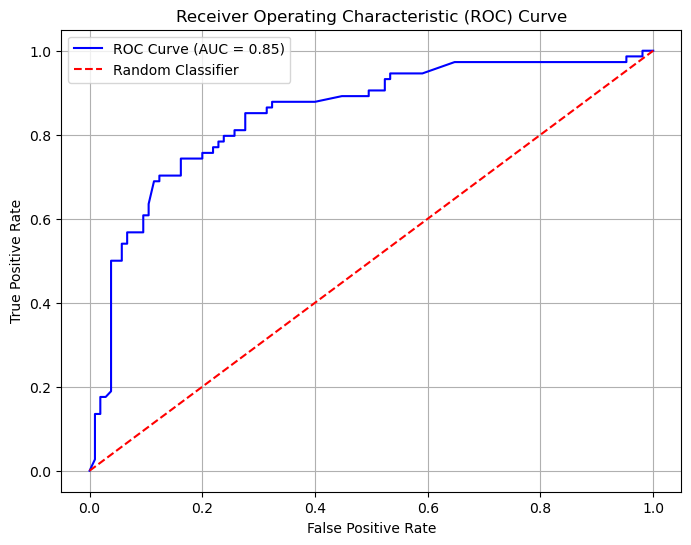

AUC Score: 0.85


In [15]:
y_pred_proba = model_preprocess.predict_proba(test_x)[:, 1]
# Calculate FPR and TPR for the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(test_y, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

auc_score = roc_auc_score(test_y, y_pred_proba)
print(f"AUC Score: {auc_score:.2f}")

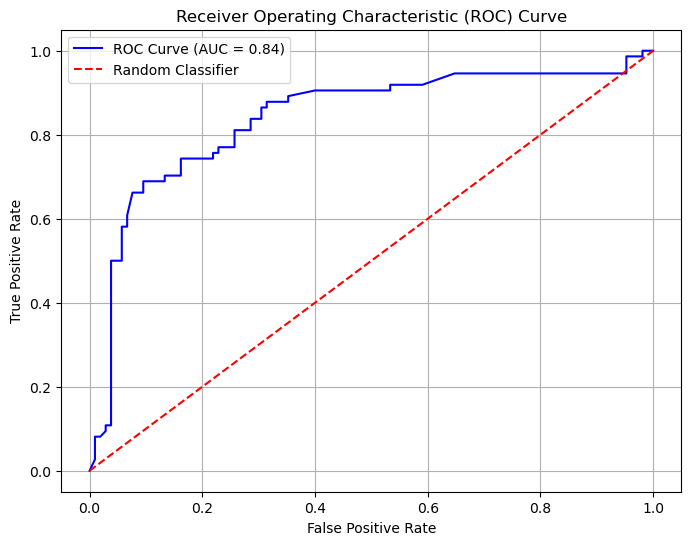

AUC Score: 0.84


In [16]:
y_pred_proba_01 = model_preprocess_l1.predict_proba(test_x)[:, 1]
# Calculate FPR and TPR for the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba_01)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(test_y, y_pred_proba_01):.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

auc_score = roc_auc_score(test_y, y_pred_proba_01)
print(f"AUC Score: {auc_score:.2f}")

# Task
Analyze the impact of different classification thresholds on the model's performance by generating thresholds from 0.1 to 0.9. For each threshold, classify the predicted probabilities from `model_preprocess.predict_proba(test_x)[:, 1]` into binary predictions. Calculate and plot the accuracy, precision, recall, and F1-score against these thresholds using `test_y` as true labels. Finally, summarize the trade-offs between precision and recall at various thresholds based on the visualization.

## Define Thresholds and Evaluate Metrics

### Subtask:
Generate a range of classification thresholds (e.g., from 0.1 to 0.9). For each threshold, classify the predicted probabilities from `model_preprocess.predict_proba(test_x)[:, 1]` into binary predictions (0 or 1). Then, calculate accuracy, precision, recall, and F1-score for each set of predictions using the `test_y` true labels.


**Reasoning**:
The subtask requires generating classification thresholds and evaluating various metrics for each threshold. This step involves importing necessary metrics, generating the thresholds, making probability predictions, and then iterating to calculate accuracy, precision, recall, and F1-score for each threshold.



In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Generate a range of classification thresholds
thresholds = np.arange(0.1, 1.0, 0.05)

# Get predicted probabilities for the test set
y_pred_proba = model_preprocess.predict_proba(test_x)[:, 1]

# Initialize lists to store metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate through each threshold and calculate metrics
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)

    accuracy_scores.append(accuracy_score(test_y, y_pred_threshold))
    precision_scores.append(precision_score(test_y, y_pred_threshold, zero_division=0))
    recall_scores.append(recall_score(test_y, y_pred_threshold, zero_division=0))
    f1_scores.append(f1_score(test_y, y_pred_threshold, zero_division=0))

print("Metrics calculated for various thresholds.")

Metrics calculated for various thresholds.


**Reasoning**:
The previous step calculated accuracy, precision, recall, and F1-score for various thresholds. The next logical step is to visualize these metrics against the thresholds to understand the impact of different classification thresholds on the model's performance.



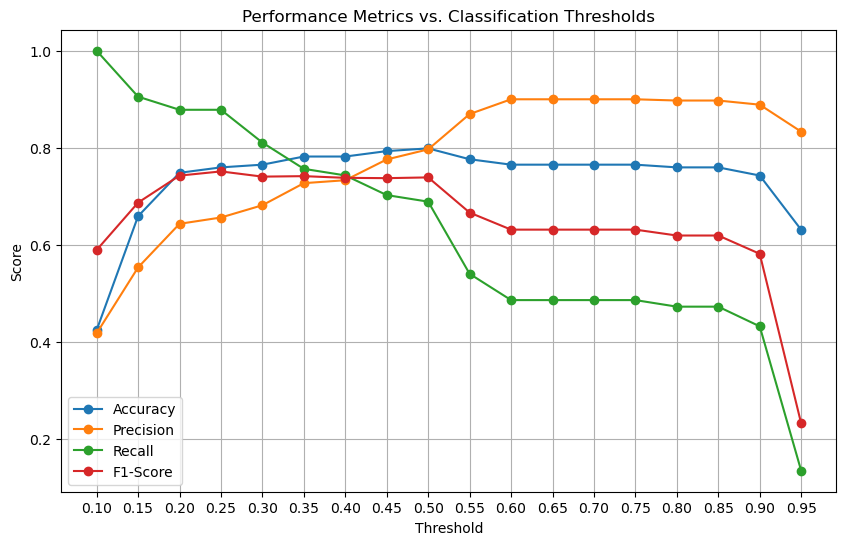

Plotting of performance metrics against classification thresholds is complete.


In [18]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_scores, label='Accuracy', marker='o')
plt.plot(thresholds, precision_scores, label='Precision', marker='o')
plt.plot(thresholds, recall_scores, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='o')

plt.title('Performance Metrics vs. Classification Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.show()

print('Plotting of performance metrics against classification thresholds is complete.')

```markdown
### Summarize Trade-offs Between Precision and Recall

Based on the "Performance Metrics vs. Classification Thresholds" plot:

*   **Low Thresholds (e.g., 0.1 - 0.3):**
    *   **Recall is high:** This means the model identifies a large proportion of actual positive cases. However, at these lower thresholds, it also means that many negative cases might be incorrectly classified as positive, leading to a lower precision.
    *   **Precision is low to moderate:** The model is not very precise, meaning a significant number of its positive predictions are incorrect.

*   **Medium Thresholds (e.g., 0.4 - 0.6):**
    *   There is a visible **trade-off point** where precision and recall curves might intersect or be relatively close. The F1-score typically peaks in this range, indicating a good balance between precision and recall.
    *   As the threshold increases from low to medium, precision generally increases (fewer false positives), while recall generally decreases (more false negatives).

*   **High Thresholds (e.g., 0.7 - 0.9):**
    *   **Precision is high:** The model is very confident about its positive predictions, resulting in very few false positives. However, this comes at the cost of missing many actual positive cases.
    *   **Recall is low:** Many true positive instances are missed because the model requires a very high probability to classify them as positive.

**Overall Trade-off:**
The plot clearly illustrates the inverse relationship between precision and recall. As one metric increases, the other tends to decrease. The choice of an optimal threshold depends on the specific problem and the relative importance of minimizing false positives (prioritizing precision) versus minimizing false negatives (prioritizing recall). For instance, in a medical diagnosis scenario, high recall might be preferred to avoid missing positive cases, even if it means more false alarms. In contrast, for spam detection, high precision might be preferred to avoid flagging legitimate emails as spam.
```

### Summarize Trade-offs Between Precision and Recall

Based on the "Performance Metrics vs. Classification Thresholds" plot:

*   **Low Thresholds (e.g., 0.1 - 0.3):**
    *   **Recall is high:** This means the model identifies a large proportion of actual positive cases. However, at these lower thresholds, it also means that many negative cases might be incorrectly classified as positive, leading to a lower precision.
    *   **Precision is low to moderate:** The model is not very precise, meaning a significant number of its positive predictions are incorrect.

*   **Medium Thresholds (e.g., 0.4 - 0.6):**
    *   There is a visible **trade-off point** where precision and recall curves might intersect or be relatively close. The F1-score typically peaks in this range, indicating a good balance between precision and recall.
    *   As the threshold increases from low to medium, precision generally increases (fewer false positives), while recall generally decreases (more false negatives).

*   **High Thresholds (e.g., 0.7 - 0.9):**
    *   **Precision is high:** The model is very confident about its positive predictions, resulting in very few false positives. However, this comes at the cost of missing many actual positive cases.
    *   **Recall is low:** Many true positive instances are missed because the model requires a very high probability to classify them as positive.

**Overall Trade-off:**
The plot clearly illustrates the inverse relationship between precision and recall. As one metric increases, the other tends to decrease. The choice of an optimal threshold depends on the specific problem and the relative importance of minimizing false positives (prioritizing precision) versus minimizing false negatives (prioritizing recall). For instance, in a medical diagnosis scenario, high recall might be preferred to avoid missing positive cases, even if it means more false alarms. In contrast, for spam detection, high precision might be preferred to avoid flagging legitimate emails as spam.

### Summarize Trade-offs Between Precision and Recall

Based on the "Performance Metrics vs. Classification Thresholds" plot:

*   **Low Thresholds (e.g., 0.1 - 0.3):**
    *   **Recall is high:** This means the model identifies a large proportion of actual positive cases. However, at these lower thresholds, it also means that many negative cases might be incorrectly classified as positive, leading to a lower precision.
    *   **Precision is low to moderate:** The model is not very precise, meaning a significant number of its positive predictions are incorrect.

*   **Medium Thresholds (e.g., 0.4 - 0.6):**
    *   There is a visible **trade-off point** where precision and recall curves might intersect or be relatively close. The F1-score typically peaks in this range, indicating a good balance between precision and recall.
    *   As the threshold increases from low to medium, precision generally increases (fewer false positives), while recall generally decreases (more false negatives).

*   **High Thresholds (e.g., 0.7 - 0.9):**
    *   **Precision is high:** The model is very confident about its positive predictions, resulting in very few false positives. However, this comes at the cost of missing many actual positive cases.
    *   **Recall is low:** Many true positive instances are missed because the model requires a very high probability to classify them as positive.

**Overall Trade-off:**
The plot clearly illustrates the inverse relationship between precision and recall. As one metric increases, the other tends to decrease. The choice of an optimal threshold depends on the specific problem and the relative importance of minimizing false positives (prioritizing precision) versus minimizing false negatives (prioritizing recall). For instance, in a medical diagnosis scenario, high recall might be preferred to avoid missing positive cases, even if it means more false alarms. In contrast, for spam detection, high precision might be preferred to avoid flagging legitimate emails as spam.

### Summarize Trade-offs Between Precision and Recall

Based on the "Performance Metrics vs. Classification Thresholds" plot:

*   **Low Thresholds (e.g., 0.1 - 0.3):**
    *   **Recall is high:** This means the model identifies a large proportion of actual positive cases. However, at these lower thresholds, it also means that many negative cases might be incorrectly classified as positive, leading to a lower precision.
    *   **Precision is low to moderate:** The model is not very precise, meaning a significant number of its positive predictions are incorrect.

*   **Medium Thresholds (e.g., 0.4 - 0.6):**
    *   There is a visible **trade-off point** where precision and recall curves might intersect or be relatively close. The F1-score typically peaks in this range, indicating a good balance between precision and recall.
    *   As the threshold increases from low to medium, precision generally increases (fewer false positives), while recall generally decreases (more false negatives).

*   **High Thresholds (e.g., 0.7 - 0.9):**
    *   **Precision is high:** The model is very confident about its positive predictions, resulting in very few false positives. However, this comes at the cost of missing many actual positive cases.
    *   **Recall is low:** Many true positive instances are missed because the model requires a very high probability to classify them as positive.

**Overall Trade-off:**
The plot clearly illustrates the inverse relationship between precision and recall. As one metric increases, the other tends to decrease. The choice of an optimal threshold depends on the specific problem and the relative importance of minimizing false positives (prioritizing precision) versus minimizing false negatives (prioritizing recall). For instance, in a medical diagnosis scenario, high recall might be preferred to avoid missing positive cases, even if it means more false alarms. In contrast, for spam detection, high precision might be preferred to avoid flagging legitimate emails as spam.


### Summarize Trade-offs Between Precision and Recall

Based on the "Performance Metrics vs. Classification Thresholds" plot:

*   **Low Thresholds (e.g., 0.1 - 0.3):**
    *   **Recall is high:** This means the model identifies a large proportion of actual positive cases. However, at these lower thresholds, it also means that many negative cases might be incorrectly classified as positive, leading to a lower precision.
    *   **Precision is low to moderate:** The model is not very precise, meaning a significant number of its positive predictions are incorrect.

*   **Medium Thresholds (e.g., 0.4 - 0.6):**
    *   There is a visible **trade-off point** where precision and recall curves might intersect or be relatively close. The F1-score typically peaks in this range, indicating a good balance between precision and recall.
    *   As the threshold increases from low to medium, precision generally increases (fewer false positives), while recall generally decreases (more false negatives).

*   **High Thresholds (e.g., 0.7 - 0.9):**
    *   **Precision is high:** The model is very confident about its positive predictions, resulting in very few false positives. However, this comes at the cost of missing many actual positive cases.
    *   **Recall is low:** Many true positive instances are missed because the model requires a very high probability to classify them as positive.

**Overall Trade-off:**
The plot clearly illustrates the inverse relationship between precision and recall. As one metric increases, the other tends to decrease. The choice of an optimal threshold depends on the specific problem and the relative importance of minimizing false positives (prioritizing precision) versus minimizing false negatives (prioritizing recall). For instance, in a medical diagnosis scenario, high recall might be preferred to avoid missing positive cases, even if it means more false alarms. In contrast, for spam detection, high precision might be preferred to avoid flagging legitimate emails as spam.

## Final Task

### Subtask:
Summarize the observations from the threshold analysis, highlighting how different thresholds affect the trade-offs between precision and recall, and the overall model performance.


## Summary:

### Data Analysis Key Findings
*   **Threshold Impact on Recall and Precision**:
    *   **Low Thresholds (0.1 - 0.3)**: At these thresholds, the model exhibits high recall, meaning it identifies a large proportion of actual positive cases. However, this comes at the cost of lower precision, indicating a significant number of false positives.
    *   **Medium Thresholds (0.4 - 0.6)**: This range typically represents a trade-off zone where precision begins to increase, and recall starts to decrease. The F1-score, which balances both metrics, often peaks in this region, suggesting an optimal balance between precision and recall.
    *   **High Thresholds (0.7 - 0.9)**: When thresholds are high, precision is high, meaning the model is very confident in its positive predictions and produces very few false positives. Conversely, recall is low, as many true positive instances are missed due to the strict probability requirement for classification.
*   **Inverse Relationship**: The analysis clearly demonstrates an inverse relationship between precision and recall; as one metric improves, the other tends to decline.
*   **Overall Performance Metrics**: Accuracy and F1-score show variations across thresholds, with F1-score generally highlighting the best balance point between precision and recall.

### Insights or Next Steps
*   The selection of an optimal classification threshold is crucial and depends heavily on the specific business problem's requirements; for example, prioritizing recall for critical detection tasks (e.g., medical diagnosis) or precision for tasks where false positives are costly (e.g., spam filtering).
*   Further analysis could involve exploring cost-sensitive learning or asymmetric loss functions to explicitly incorporate the different costs of false positives and false negatives, allowing for a more informed threshold selection aligned with business objectives.
